In [13]:
# necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
# data import and overview of data

data = pd.read_csv(r'mcdonalds.csv')
print (f"The dataset contains {data.shape[0]} instances and {data.shape[1]} features and the features are:\n{data.columns.to_list()}")
data.head()

The dataset contains 1453 instances and 15 features and the features are:
['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']


,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [15]:
# checking for number of null values for each feature

data.isnull().sum()

yummy             0
convenient        0
spicy             0
fattening         0
greasy            0
fast              0
cheap             0
tasty             0
expensive         0
healthy           0
disgusting        0
Like              0
Age               0
VisitFrequency    0
Gender            0
dtype: int64

In [16]:
# converting the yes's to 1 and no's to 0

data.replace(
    {
        'Yes' : 1,
        'No' : 0
    },
    inplace=True
)
data.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,Every three months,Female
1,1,1,0,1,1,1,1,1,1,0,0,+2,51,Every three months,Female
2,0,1,1,1,1,1,0,1,1,1,0,+1,62,Every three months,Female
3,1,1,0,1,1,1,1,1,0,0,1,+4,69,Once a week,Female
4,0,1,0,1,1,1,1,0,0,1,0,+2,49,Once a month,Male


In [17]:
#converting the gender column into numerical values using OneHotEncoder

encoder = OneHotEncoder(
    categories=[['Female', 'Male']],
    sparse_output=False,
    drop='first', # dropping one column to eliminate multicolinearity problem
    dtype=np.int8
).fit(data[['Gender']])

data['Gender_Male'] = encoder.transform(data[['Gender']])

data.drop(
    columns='Gender',
    inplace=True
)
data.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender_Male
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,Every three months,0
1,1,1,0,1,1,1,1,1,1,0,0,+2,51,Every three months,0
2,0,1,1,1,1,1,0,1,1,1,0,+1,62,Every three months,0
3,1,1,0,1,1,1,1,1,0,0,1,+4,69,Once a week,0
4,0,1,0,1,1,1,1,0,0,1,0,+2,49,Once a month,1


In [18]:
# only the first 11 columns and the gender_male column will be used as segmentation variable and the VisitFrequency and the Like column
# will be used as descriptor variable

X = data.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
X.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
0,0,1,0,1,0,1,1,0,1,0,0
1,1,1,0,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,0,1,1,1,0
3,1,1,0,1,1,1,1,1,0,0,1
4,0,1,0,1,1,1,1,0,0,1,0


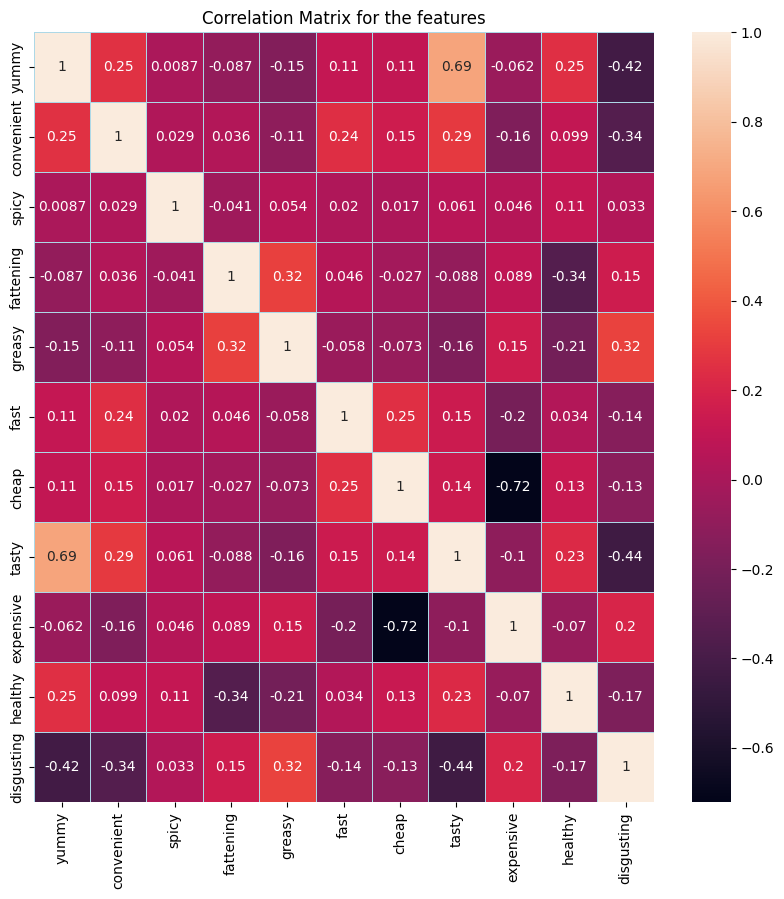

In [19]:
# checking for correlation among different features

corr_matrix = X.corr()

plt.figure(figsize=(10,10))
sns.heatmap(
    data=corr_matrix,
    annot=True,
    fmt='.2g',
    linewidths=0.5,
    linecolor='lightblue'
)
plt.title('Correlation Matrix for the features')
plt.show()

Here, from the correlation matrix we can see that there is a moderate negative correlation between the features expensive and cheap and a moderate positive correlation between the features yummy and tasty.

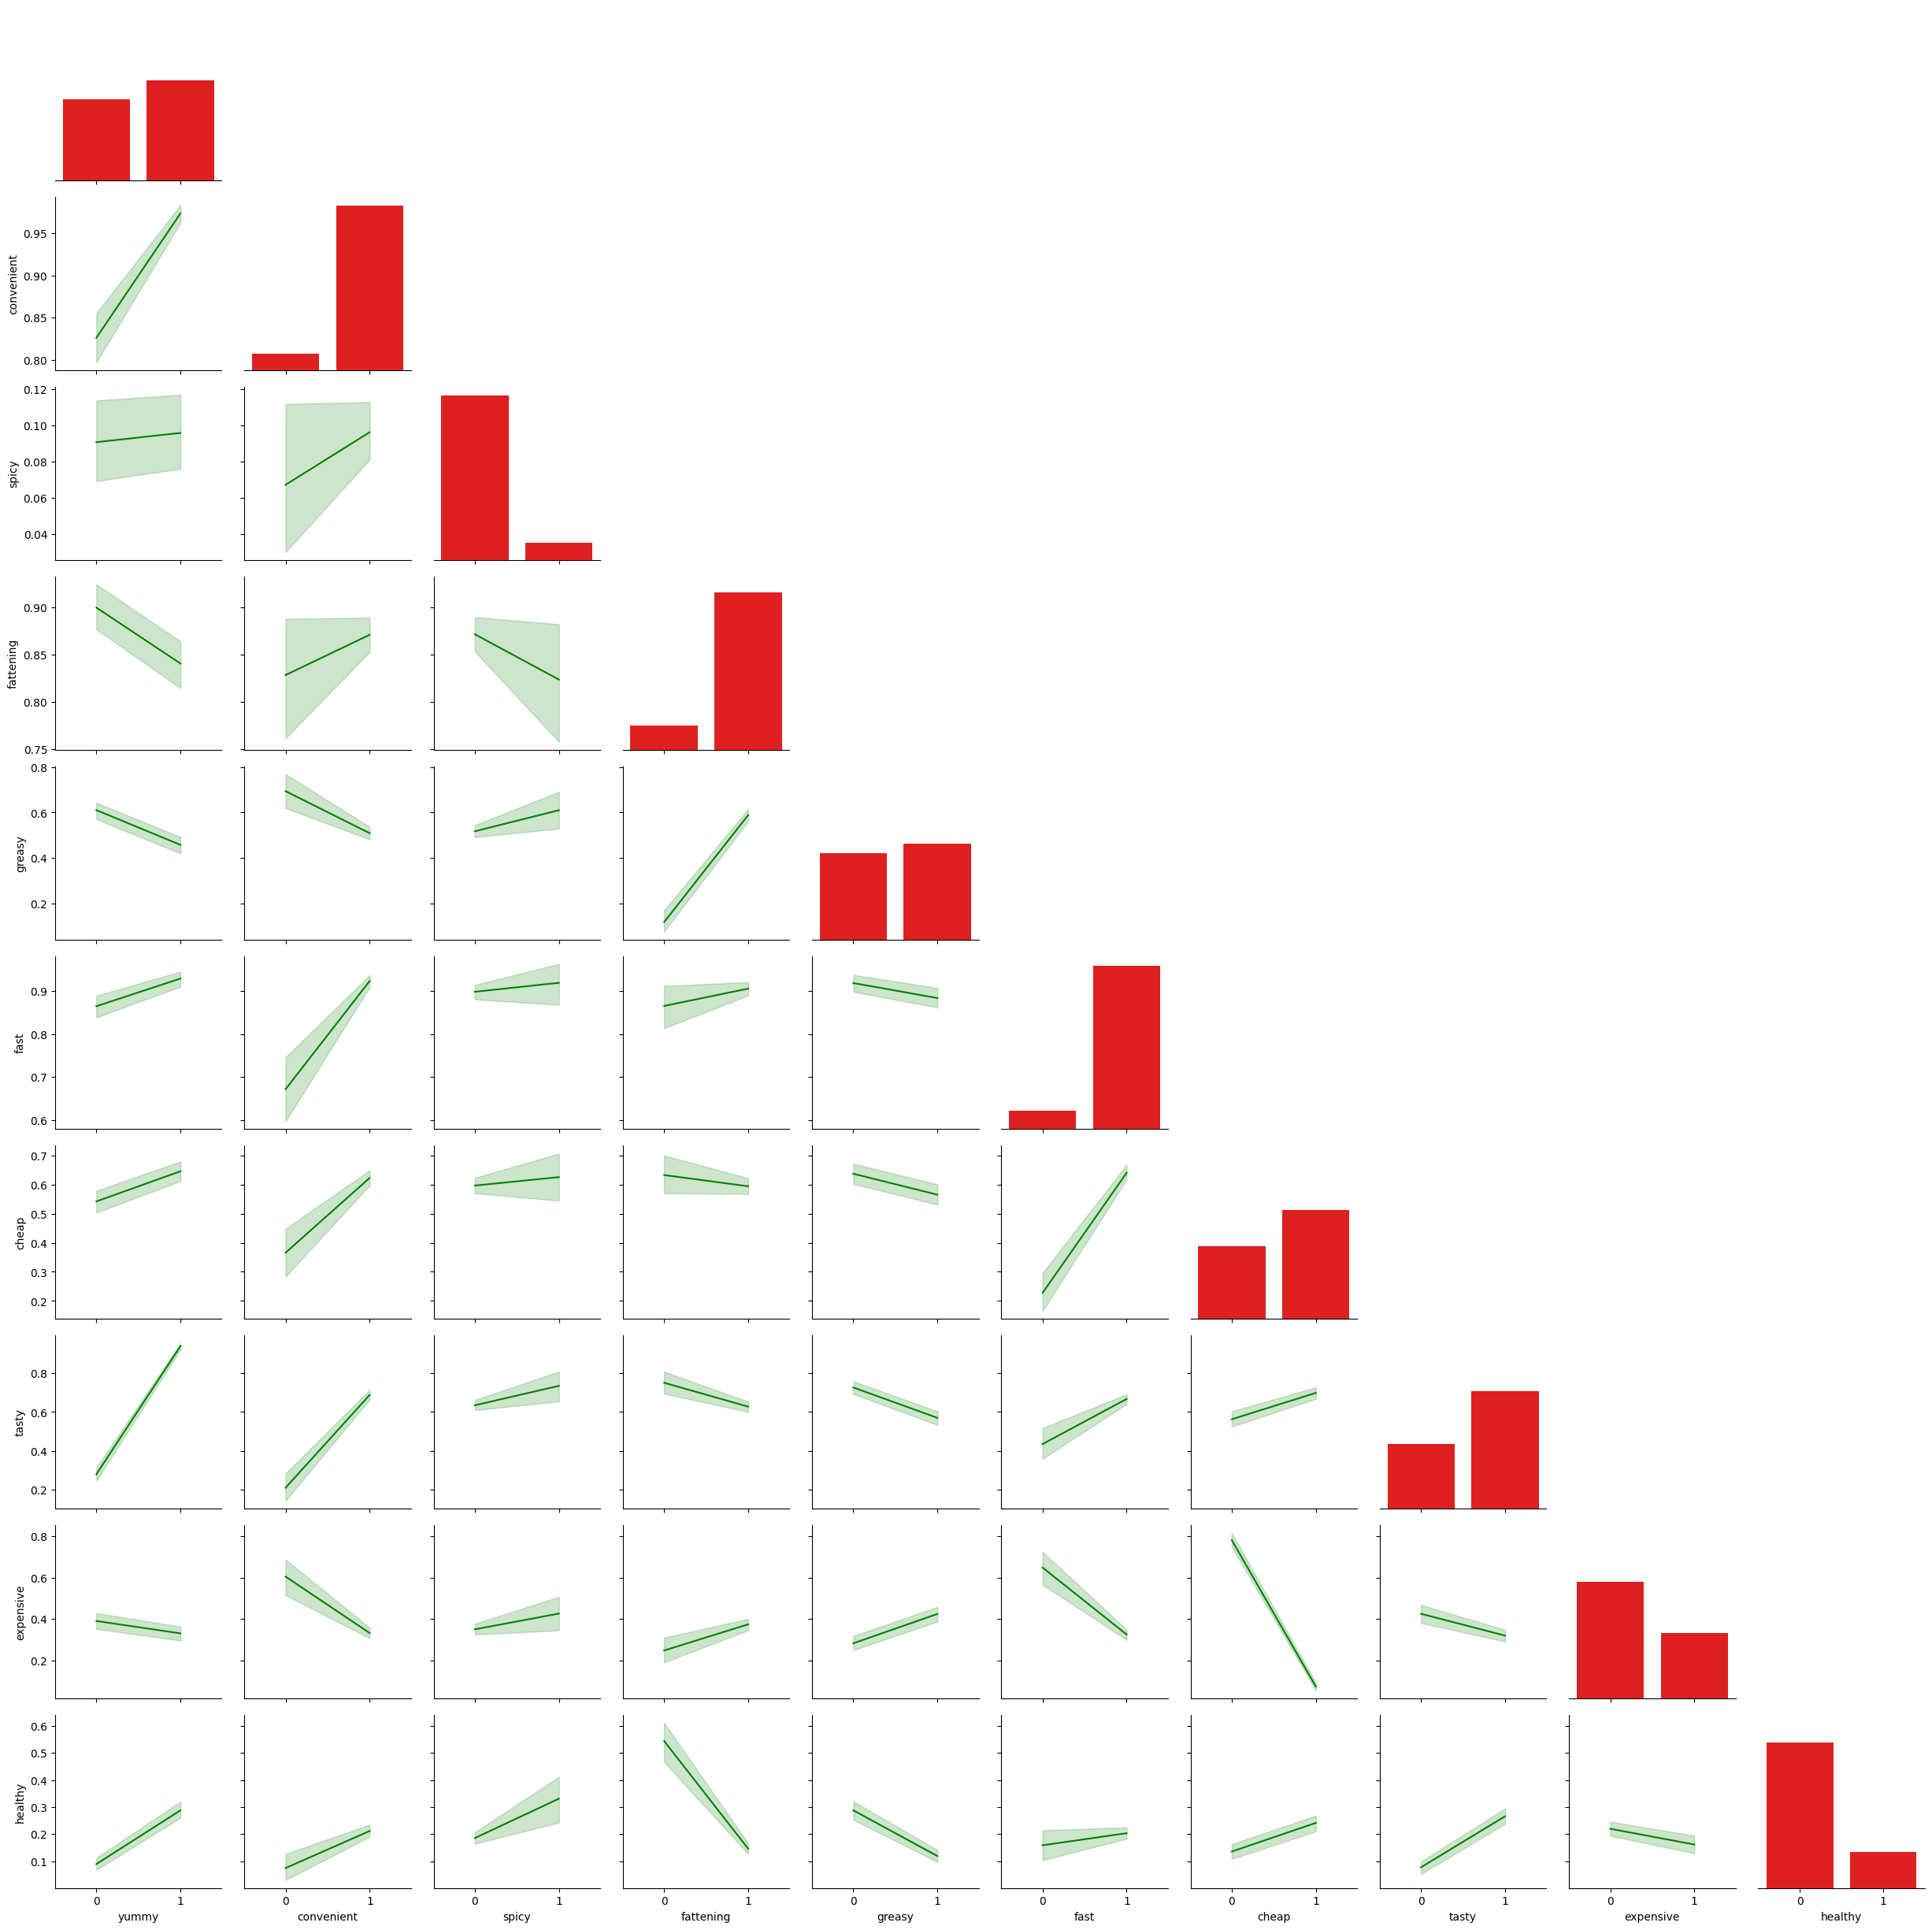

In [20]:
# pair plot for getting an overall idea about the data

grid = sns.PairGrid(X.iloc[:,:-1], corner=True)
grid.map_diag(sns.countplot, color='red')
grid.map_lower(sns.lineplot, color='green')
plt.show()

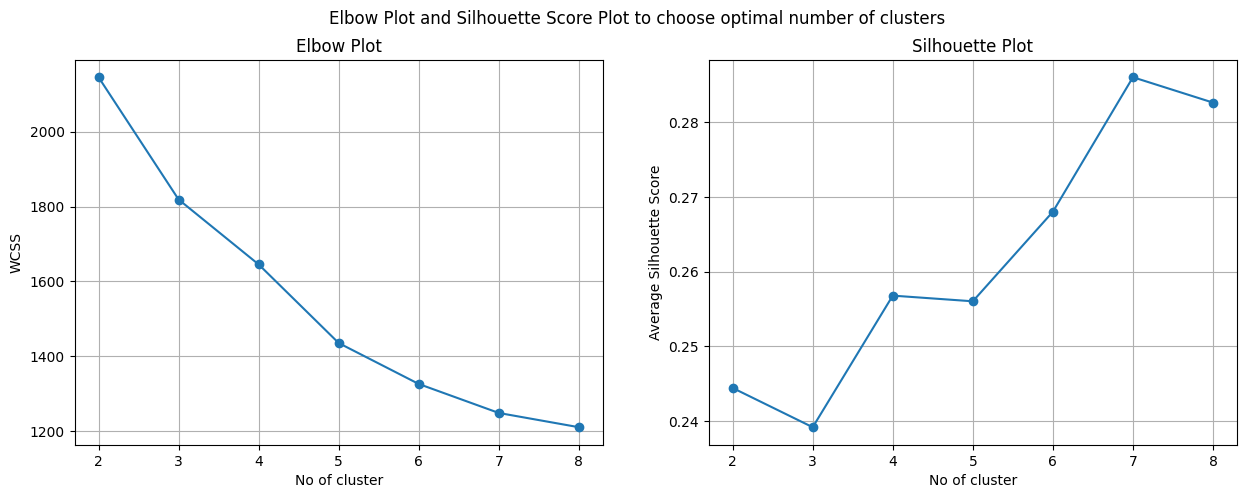

In [21]:
# as all the columns are only binary, we will not scale the columns and directly proceed with these
# using elbow plot and a plot of silhouette score vs number of cluster to get an idea of what will be the best number of segments

def elbow_plot(min_k:int, max_k:int, data, n_init='auto'):
    import numpy as np
    from sklearn.cluster import KMeans
    
    wcss = list()
    for i in range(min_k, max_k+1):
        model = KMeans(
            n_clusters = i,
            init = 'k-means++'
        ).fit(X)
        wcss.append(model.inertia_)
    wcss = np.array(wcss)
    k_size = np.arange(min_k, max_k+1, 1)

    return (k_size, wcss)


def silhouette_plot(min_k:int, max_k:int, data):
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    
    score = list()
    for i in range(min_k, max_k+1):
        model = KMeans(
            n_clusters = i,
            init = 'k-means++'
        ).fit(X)
        score.append(silhouette_score(X, model.predict(X)))
    score = np.array(score)
    k_size = np.arange(min_k, max_k+1, 1)

    return (k_size, score)

elbow_k, elbow_wcss = elbow_plot(2, 8, X)
sil_k, sil_score = silhouette_plot(2, 8, X)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.suptitle('Elbow Plot and Silhouette Score Plot to choose optimal number of clusters')
ax[0].plot(elbow_k, elbow_wcss, marker='o')
ax[0].grid()
ax[0].set_xlabel('No of cluster')
ax[0].set_ylabel('WCSS')
ax[0].set_title('Elbow Plot')
ax[1].plot(sil_k, sil_score, marker='o')
ax[1].grid()
ax[1].set_xlabel('No of cluster')
ax[1].set_ylabel('Average Silhouette Score')
ax[1].set_title('Silhouette Plot')
plt.show()

Considering the elbow plot and the average silhouette score we can choose 4 to be an optimal number of clusters

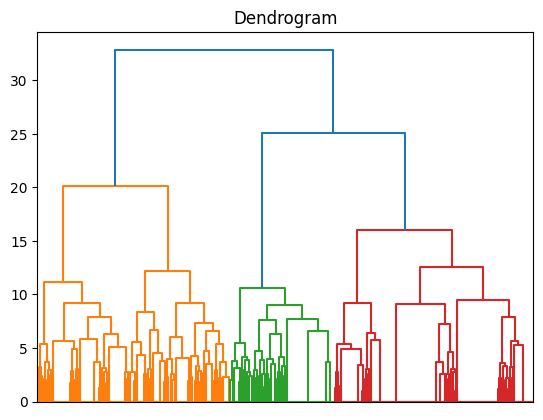

In [22]:
linkage_analysis = linkage(X, method='ward')
dendrogram(linkage_analysis, no_labels=True)
plt.title('Dendrogram')
plt.show()

From the dendrogram, 3 seems to be the optimal number of clusters but considering the Elbow plot and the Silhouette plot, we can choose 4 as the optimal number of cluster

In [36]:
# performing k_means clustering with 3 clusters

model = KMeans(
    init = 'k-means++',
    n_init = 10,
    n_clusters = 3
).fit(X)
prediction = model.predict(X)
X.loc[:,'Assigned_Cluster'] = prediction
X.sample(5)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Assigned_Cluster
1111,0,1,0,1,1,1,1,0,0,0,0,1
112,0,0,0,1,1,0,0,0,1,0,1,1
723,0,1,0,1,0,1,1,0,0,0,0,1
1258,1,1,0,0,0,1,1,1,0,1,0,0
65,0,0,0,1,0,1,0,0,1,0,1,1


In [37]:
# getting the average values for each of the features that will be further used for segment profiling

features_overall_means = X.iloc[:,:-1].mean(axis='index').reset_index()
features_overall_means.rename(
    columns = {
        'index' : 'Feature',
        0 : 'Overall Mean'
    },
    inplace=True
)
features_overall_means

,Feature,Overall Mean
0,yummy,0.552650
1,convenient,0.907777
2,spicy,0.093599
3,fattening,0.867171
4,greasy,0.526497
5,fast,0.900206
6,cheap,0.598761
7,tasty,0.644184
8,expensive,0.357880
9,healthy,0.198899


In [38]:
profile_table = X.groupby('Assigned_Cluster').mean().T.reset_index().rename(
    columns={
        'index':'Feature'
    }
)
profile_table

Assigned_Cluster,Feature,0,1,2
0,yummy,0.843042,0.014085,0.813609
1,convenient,0.980583,0.782696,0.958580
2,spicy,0.088997,0.076459,0.127219
3,fattening,0.804207,0.919517,0.905325
4,greasy,0.365696,0.661972,0.621302
5,fast,0.962783,0.847082,0.863905
6,cheap,0.928803,0.527163,0.100592
7,tasty,0.964401,0.046278,0.937870
8,expensive,0.017799,0.404427,0.911243
9,healthy,0.304207,0.062374,0.207101


In [39]:
profile_table = pd.merge(profile_table, features_overall_means, how='inner', on='Feature')
profile_table

,Feature,0,1,2,Overall Mean
0,yummy,0.843042,0.014085,0.813609,0.552650
1,convenient,0.980583,0.782696,0.958580,0.907777
2,spicy,0.088997,0.076459,0.127219,0.093599
3,fattening,0.804207,0.919517,0.905325,0.867171
4,greasy,0.365696,0.661972,0.621302,0.526497
5,fast,0.962783,0.847082,0.863905,0.900206
6,cheap,0.928803,0.527163,0.100592,0.598761
7,tasty,0.964401,0.046278,0.937870,0.644184
8,expensive,0.017799,0.404427,0.911243,0.357880
9,healthy,0.304207,0.062374,0.207101,0.198899


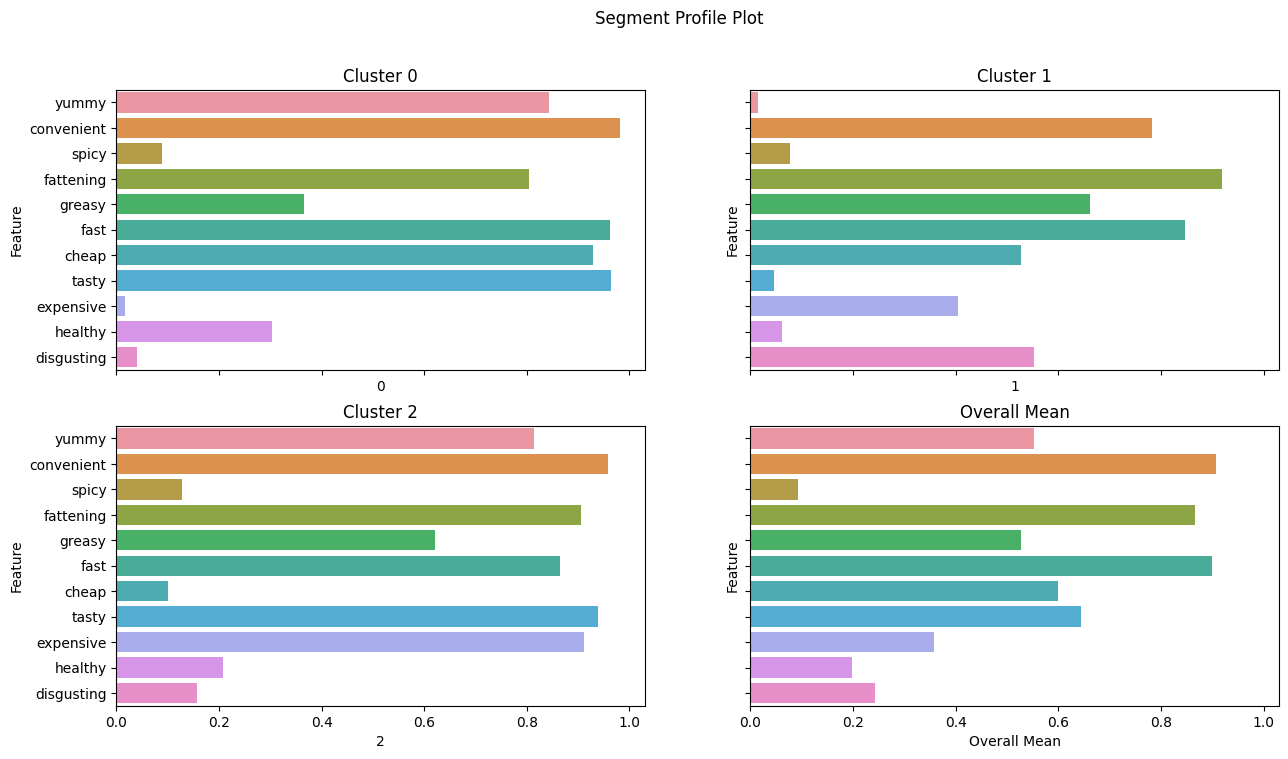

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15,8))
plt.suptitle('Segment Profile Plot')
sns.barplot(ax=ax[0,0], data=profile_table, x=0, y='Feature', errorbar=None)
ax[0,0].set_title('Cluster 0')
sns.barplot(ax=ax[0,1], data=profile_table, x=1, y='Feature', errorbar=None)
ax[0,1].set_title('Cluster 1')
sns.barplot(ax=ax[1,0], data=profile_table, x=2, y='Feature', errorbar=None)
ax[1,0].set_title('Cluster 2')
sns.barplot(ax=ax[1,1], data=profile_table, x='Overall Mean', y='Feature', errorbar=None)
ax[1,1].set_title('Overall Mean')
plt.show()

### Performing PCA for cluster visualization

In [41]:
X.iloc[:,:-1].head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
0,0,1,0,1,0,1,1,0,1,0,0
1,1,1,0,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,0,1,1,1,0
3,1,1,0,1,1,1,1,1,0,0,1
4,0,1,0,1,1,1,1,0,0,1,0


In [42]:
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X.iloc[:,:-1])

# generating a list like PC1, PC2 ... PC11
pc_list = []
for i in range(1, 12):
    pc_list.append('PC'+str(i))

X_pca = pd.DataFrame(
    data=X_pca,
    columns=pc_list
)
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,0.425367,-0.219079,0.663255,-0.401300,0.201705,-0.389767,-0.211982,0.163235,0.181007,0.515706,-0.567074
1,-0.218638,0.388190,-0.730827,-0.094724,0.044669,-0.086596,-0.095877,-0.034756,0.111476,0.493313,-0.500440
2,0.375415,0.730435,-0.122040,0.692262,0.839643,-0.687406,0.583112,0.364379,-0.322288,0.061759,0.242741
3,-0.172926,-0.352752,-0.843795,0.206998,-0.681415,-0.036133,-0.054284,-0.231477,-0.028003,-0.250678,-0.051034
4,0.187057,-0.807610,0.028537,0.548332,0.854074,-0.097305,-0.457043,0.171758,-0.074409,0.031897,0.082245


In [43]:
# variability explained by each of the principal components
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = explained_variance.cumsum()
pca_details = pd.DataFrame(
    {
        'Component' : pc_list,
        'Explained Variance': explained_variance,
        'Cumulative Explained Variance' : cum_explained_variance
    }
)
pca_details

,Component,Explained Variance,Cumulative Explained Variance
0,PC1,0.299447,0.299447
1,PC2,0.192797,0.492244
2,PC3,0.133045,0.625290
3,PC4,0.083096,0.708386
4,PC5,0.059481,0.767866
5,PC6,0.050300,0.818166
6,PC7,0.043849,0.862015
7,PC8,0.039548,0.901563
8,PC9,0.036761,0.938323
9,PC10,0.032353,0.970677


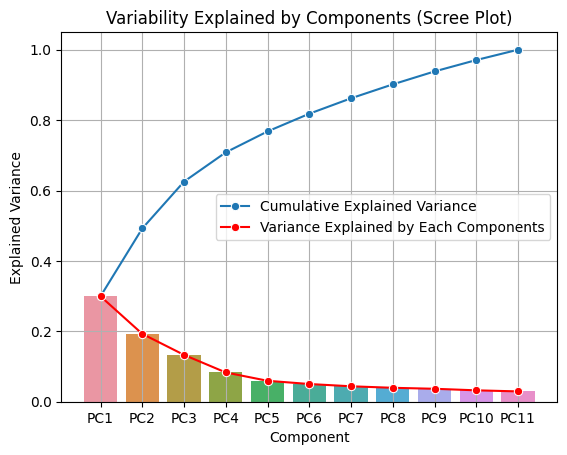

In [44]:
# scree plot

sns.barplot(data=pca_details, x='Component', y='Explained Variance')
sns.lineplot(data=pca_details, x='Component', y='Cumulative Explained Variance', marker='o', label='Cumulative Explained Variance')
sns.lineplot(data=pca_details, x='Component', y='Explained Variance', marker='o', label='Variance Explained by Each Components', color='red')
plt.grid()
plt.legend()
plt.title('Variability Explained by Components (Scree Plot)')
plt.show()

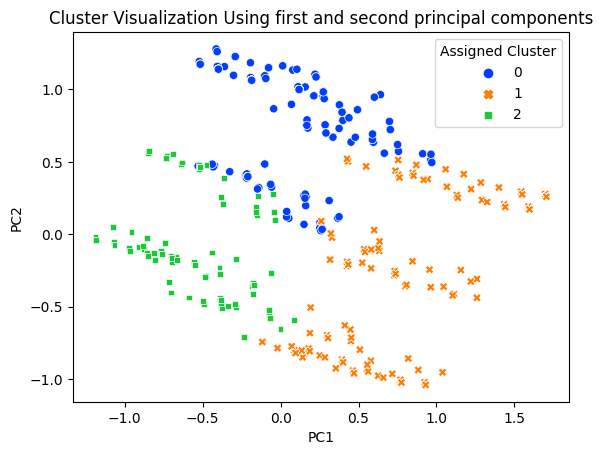

In [45]:
# visualizing the clusters using the first two components

model_pca = KMeans(
    init='k-means++',
    n_clusters=3
)
X_pca.loc[:,'Assigned Cluster'] = model_pca.fit_predict(X_pca)

sns.scatterplot(data=X_pca, x='PC1', y='PC2', style='Assigned Cluster', hue='Assigned Cluster', palette='bright')

plt.title('Cluster Visualization Using first and second principal components')
plt.show()

In [46]:
feature_names = X.iloc[:,:-1].columns.to_list()
loadings = pca.components_
loadings = pd.DataFrame(
    loadings,
    columns=feature_names,
    index=pc_list
).T
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
yummy,-0.476933,0.363790,-0.304444,0.055162,-0.307535,0.170738,-0.280519,0.013041,0.572403,-0.110284,0.045439
convenient,-0.155332,0.016414,-0.062515,-0.142425,0.277608,-0.347830,-0.059738,-0.113079,-0.018465,-0.665818,-0.541616
spicy,-0.006356,0.018809,-0.037019,0.197619,0.070620,-0.355087,0.707637,0.375934,0.400280,-0.075634,0.141730
fattening,0.116232,-0.034094,-0.322359,-0.354139,-0.073405,-0.406515,-0.385943,0.589622,-0.160512,-0.005338,0.250910
greasy,0.304443,-0.063839,-0.802373,0.253960,0.361399,0.209347,0.036170,-0.138241,-0.002847,0.008707,0.001642
fast,-0.108493,-0.086972,-0.064642,-0.097363,0.107930,-0.594632,-0.086846,-0.627799,0.166197,0.239532,0.339265
cheap,-0.337186,-0.610633,-0.149310,0.118958,-0.128973,-0.103241,-0.040449,0.140060,0.076069,0.428087,-0.489283
tasty,-0.471514,0.307318,-0.287265,-0.002547,-0.210899,-0.076914,0.360453,-0.072792,-0.639086,0.079184,0.019552
expensive,0.329042,0.601286,0.024397,0.067816,-0.003125,-0.261342,-0.068385,0.029539,0.066996,0.454399,-0.490069
healthy,-0.213711,0.076593,0.192051,0.763488,0.287846,-0.178226,-0.349616,0.176303,-0.185572,-0.038117,0.157608


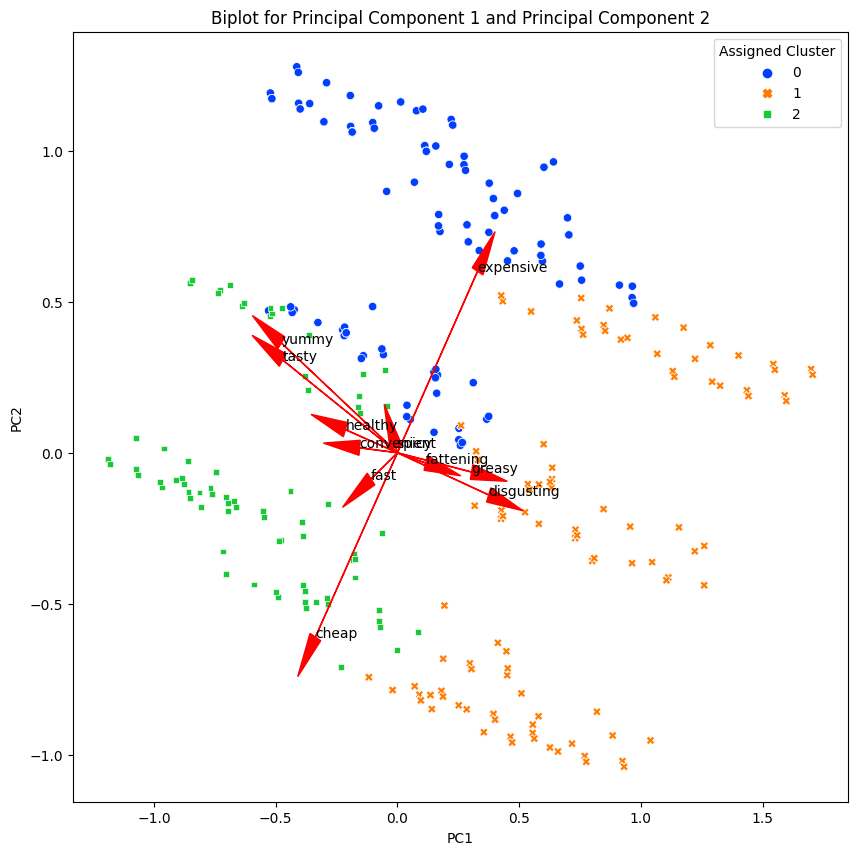

In [47]:
# biplot

# scatter plot for PC1 and PC2
plt.figure(figsize=(10,10))
sns.scatterplot(data=X_pca, x='PC1', y='PC2', style='Assigned Cluster', hue='Assigned Cluster', palette='bright')

# loading plot
for i in range(loadings.shape[0]):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1],
    color='red',
    head_length=0.15,
    head_width=0.05)
    plt.text(loadings.iloc[i, 0], loadings.iloc[i, 1], feature_names[i])

plt.title('Biplot for Principal Component 1 and Principal Component 2')
plt.show()